In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 1. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

250000000.0


In [7]:
Eb

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.    ])

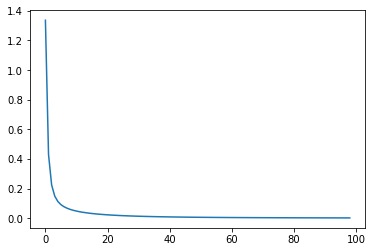

In [8]:
plt.plot(S)

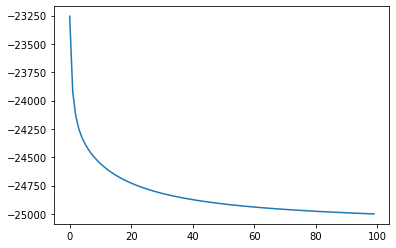

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0020856849613774104

In [11]:
eta

array([-23255.29688847, -23922.97600461, -24138.15512185, -24250.38509689,
       -24325.02469046, -24381.43561528, -24427.18605967, -24465.87793408,
       -24499.48603818, -24529.21176196, -24555.84569883, -24579.94063268,
       -24601.90190924, -24622.03821491, -24640.59186725, -24657.75781201,
       -24673.69605653, -24688.5401123 , -24702.40291448, -24715.38109062,
       -24727.55811623, -24739.00669912, -24749.79061636, -24759.96615393,
       -24769.58325256, -24778.68643208, -24787.3155461 , -24795.50640499,
       -24803.29129489, -24810.69941403, -24817.75724214, -24824.4888556 ,
       -24830.91619776, -24837.05931231, -24842.93654555, -24848.56472279,
       -24853.95930254, -24859.13451208, -24864.10346689, -24868.8782763 ,
       -24873.47013719, -24877.8894174 , -24882.14573007, -24886.24800012,
       -24890.20452389, -24894.02302259, -24897.71069053, -24901.27423855,
       -24904.71993324, -24908.05363247, -24911.28081758, -24914.40662262,
       -24917.43586094, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.74410311e+03, 1.07642400e+03, 8.61244879e+02, 7.49014904e+02,
       6.74375310e+02, 6.17964385e+02, 5.72213941e+02, 5.33522067e+02,
       4.99913962e+02, 4.70188239e+02, 4.43554302e+02, 4.19459368e+02,
       3.97498091e+02, 3.77361786e+02, 3.58808133e+02, 3.41642189e+02,
       3.25703944e+02, 3.10859888e+02, 2.96997086e+02, 2.84018910e+02,
       2.71841884e+02, 2.60393301e+02, 2.49609384e+02, 2.39433847e+02,
       2.29816748e+02, 2.20713569e+02, 2.12084455e+02, 2.03893596e+02,
       1.96108706e+02, 1.88700587e+02, 1.81642758e+02, 1.74911145e+02,
       1.68483803e+02, 1.62340688e+02, 1.56463455e+02, 1.50835278e+02,
       1.45440698e+02, 1.40265489e+02, 1.35296534e+02, 1.30521724e+02,
       1.25929863e+02, 1.21510583e+02, 1.17254271e+02, 1.13152000e+02,
       1.09195477e+02, 1.05376978e+02, 1.01689310e+02, 9.81257620e+01,
       9.46800674e+01, 9.13463681e+01, 8.81191830e+01, 8.49933780e+01,
       8.19641397e+01, 7.90269512e+01, 7.61775703e+01, 7.34120086e+01,
      